# California Housing Prices

In this project, I'll be exploring California Housing Prices from the 1990 Census. This may not be useful for predicting prices of todays markets, but the important part is the general understanding of the datastructure, how to clean data, how to do basic feature engineering, how to visualize data and how to implement basic Machine Learning methods.
The dataset can be found [here]("https://www.kaggle.com/camnugent/california-housing-prices").
This dataset is also used in the second chapter of 'Hands-On Machine Learning with Scikit-Learn and Tensorflow' by Aurélien Géron. I'll use this as reference and inspiration for my exploration.

Let's start by loading in the data and importing some needed modules:

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
df = pd.read_csv("housing.csv")

In [3]:
df.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


The data is pretty self explanatory.
* Longitude and Latitude describe the position of the district we are looking at.
* housing_median_age tells us the median age of all houses in the district.
* total_rooms gives us the total number of rooms in the district
* total_bedrooms gives us the total number of bedrooms in the district.
* population gives us the total population of the district
* households tells us, how many distinct households exist in the district.
* median_income tells us what the median_income in the district is.
* median_house_value is our target variable, describing what the median value of a house of the considered district is.
* ocean_proximity is a feature derived from the location variables. This tells us how far a district is from the ocean.


In [4]:
# shuffle the dataset:
from sklearn.utils import shuffle

df = shuffle(df)

In [5]:
df.shape

(20640, 10)

In [6]:
df.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
9225,-120.06,36.94,19.0,901.0,183.0,700.0,190.0,2.2375,64300.0,INLAND
1673,-122.26,38.03,25.0,2239.0,361.0,928.0,353.0,4.4474,203700.0,NEAR BAY
3629,-118.42,34.23,33.0,2478.0,457.0,1567.0,446.0,5.6629,186700.0,<1H OCEAN
4082,-118.38,34.16,42.0,2358.0,546.0,1065.0,523.0,3.1289,320600.0,<1H OCEAN
5074,-118.31,33.98,50.0,1985.0,454.0,1090.0,410.0,1.8250,106600.0,<1H OCEAN


Let's start with some basic exploration of our data.

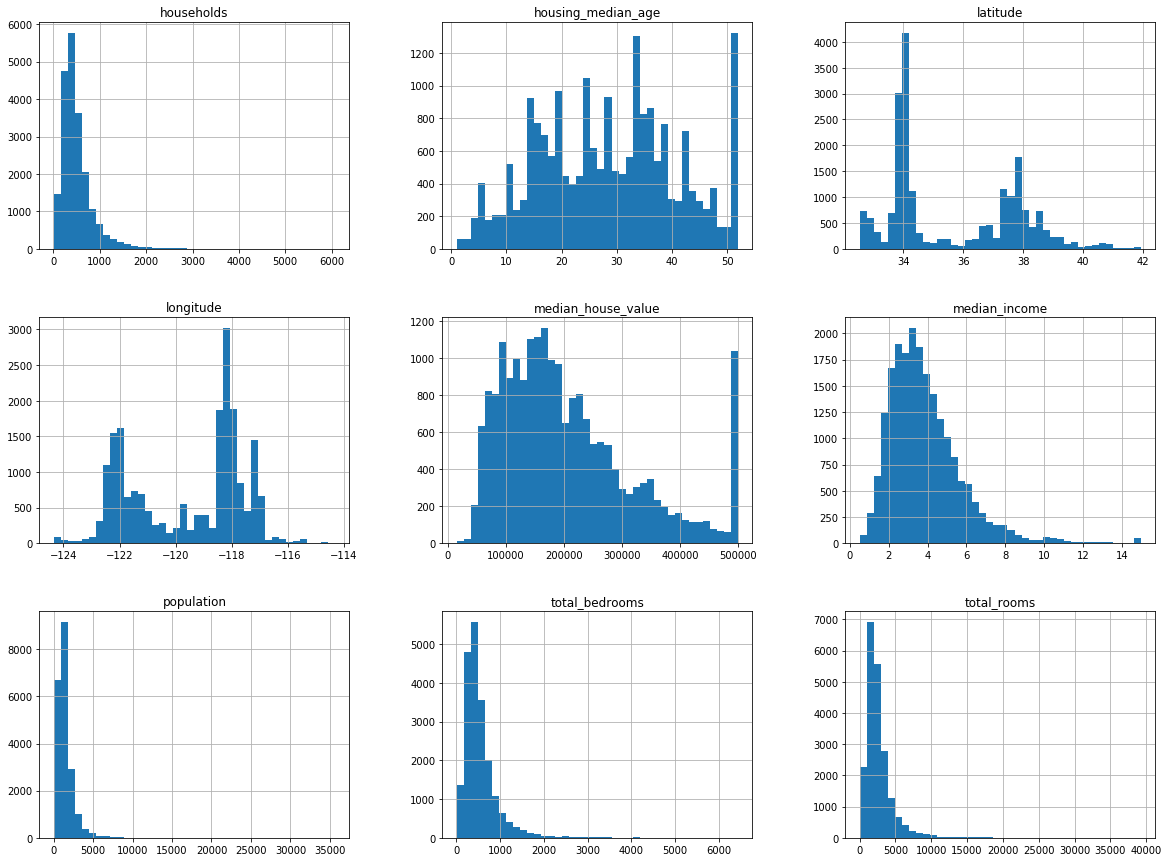

In [7]:
df.hist(bins=40, figsize=(20, 15))
plt.show()

First Observations:
<br>
* households, population, total_bedrooms, total_rooms are tail-heavy. Our goal would be a more bell-shaped distribution.
* housing_median_age: This features seems to be capped at 52 years.
* median_house_value: This feature was also capped. This may pose a problem, since this is our target attribute! <br>
If this were a real project we would now go out and try to collect fitting data for the respective districts. <br>
Removing the districts would also be possible, but we would not be able to make confident predictions for more expensive districts.
* median_income: This feature also seems to be capped of at 15. Also, the income is not represented using $US, but was instead preprocessed. <br>
The number roughly represent tens of thousands of dollars. (8 -> 80000 dollars per year)
* All features have very different scales. Especially for Deep Learning models, this is very problemativ and we'll have to take care of scaling all features.

Before we dive deeper into our data, we'll set aside a Test Set for evaluation:

In [8]:
from sklearn.model_selection import train_test_split

train_set, test_set = train_test_split(df, test_size=0.1, random_state=42) #random_state is defined to receive comparable results every time this code is run

In [9]:
train_set.shape, test_set.shape

((18576, 10), (2064, 10))

This way of sampling our test set may be fine for very large datasets. But sometimes, it is important to adhere to a certain distribution. Say, a domain expert tells you, that the median_income is probably the most important feature to predict housing prices, you would want the distribution of the whole dataset to be represented in the test set. Let's see what that would look like:

In [10]:
from sklearn.model_selection import StratifiedShuffleSplit

df["income_cat"] = pd.cut(df["median_income"],
                         bins=[0., 1.5, 3.0, 4.5, 6., np.inf],
                         labels=[1, 2, 3, 4, 5])

In [11]:
split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in split.split(df, df["income_cat"]):
    strat_train_set = df.loc[train_index]
    strat_test_set = df.loc[test_index]

Let's start with some visualizations. Using the Latitude and Logitute may be a neat visualization:

In [12]:
df = strat_train_set.copy()

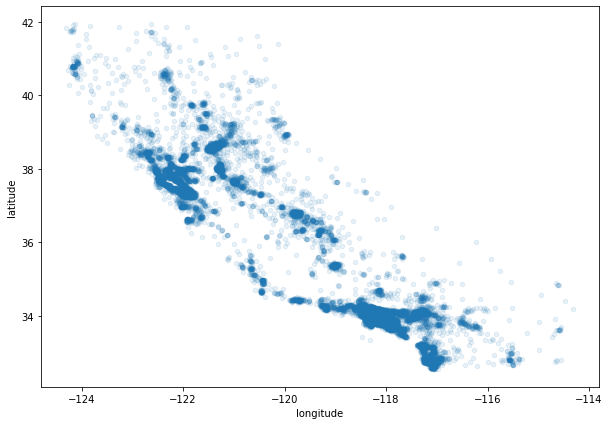

In [13]:
df.plot(kind="scatter", x ="longitude", y="latitude", alpha=0.1, figsize=(10, 7))
plt.show()

Here is a way prettier visualization of geographic data:

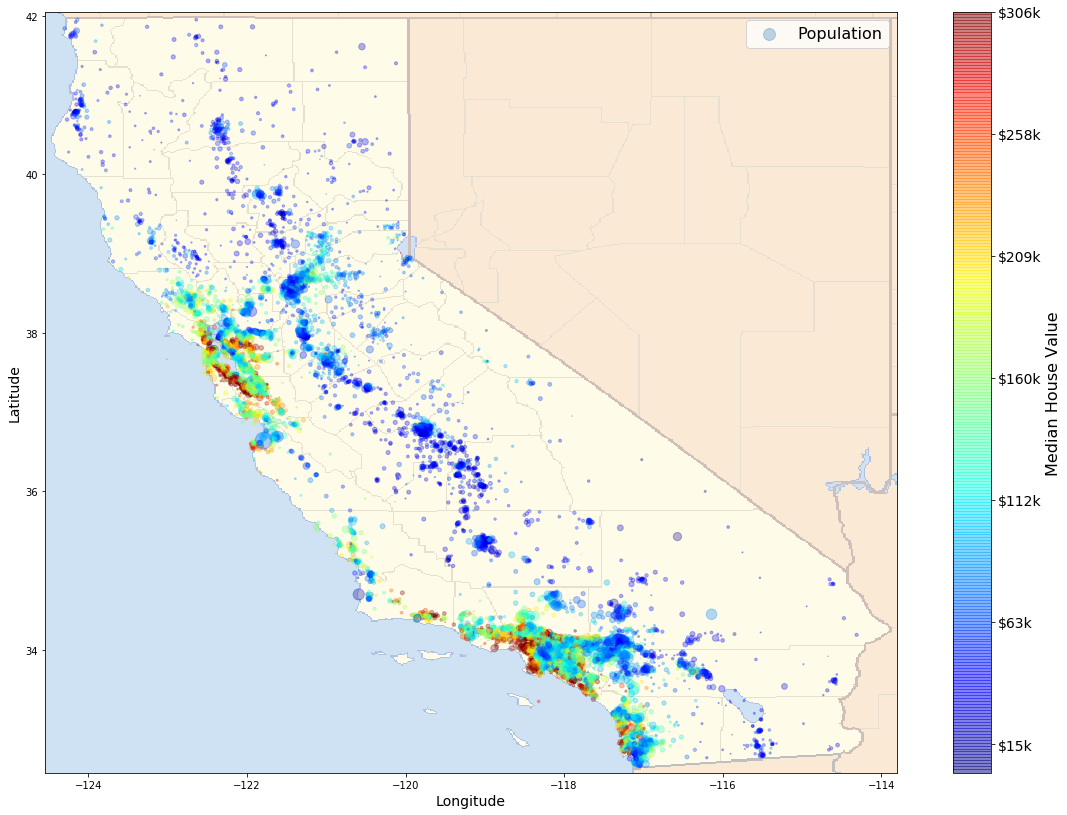

In [14]:
# inspired by "Hands On Machine Learning" by Aurélien Géron
import matplotlib.image as mpimg
california_img = mpimg.imread("california.png")
ax = df.plot(kind="scatter", x="longitude", y="latitude", figsize=(20, 14),
            s=df["population"]/100, label="Population",
            c="median_house_value", cmap=plt.get_cmap("jet"),
            colorbar=False, alpha=0.3)
plt.imshow(california_img, extent=[-124.55, -113.80, 32.45, 42.05], alpha=0.5,
          cmap=plt.get_cmap("jet"))
plt.ylabel("Latitude", fontsize=14)
plt.xlabel("Longitude", fontsize=14)

prices = df["median_house_value"]
tick_values = np.linspace(prices.min(), prices.max(), 11)
cbar = plt.colorbar()
cbar.ax.set_yticklabels(["$%dk"%(round(v/1000)) for v in tick_values], fontsize=14)
cbar.set_label("Median House Value", fontsize=16)

plt.legend(fontsize=16)
plt.show()

This gives a great overview of what our dataset can tell us. The larger a specific circle, the larger the population of that district. <br>
The colorbar-legend show which districts have a high and which have a low median house value. <br>
<br>
The next thing we'll have to check out is the correlation matrix.

In [15]:
corr_matrix = df.corr()

In [16]:
corr_matrix["median_house_value"].sort_values(ascending=False)

median_house_value    1.000000
median_income         0.685201
total_rooms           0.129300
housing_median_age    0.107857
households            0.062230
total_bedrooms        0.046213
population           -0.028826
longitude            -0.045971
latitude             -0.144118
Name: median_house_value, dtype: float64

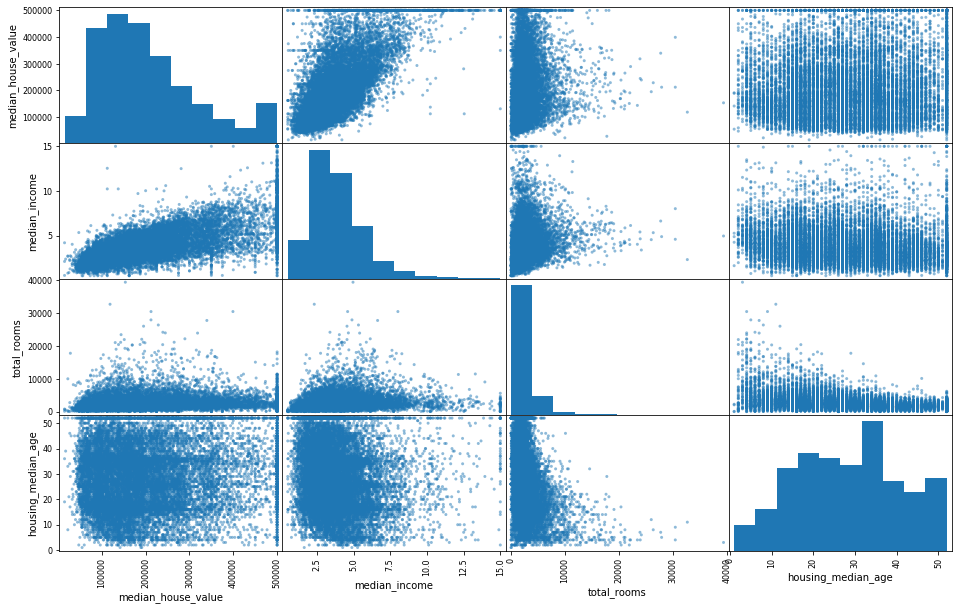

In [17]:
from pandas.plotting import scatter_matrix

attributes = ["median_house_value", "median_income", "total_rooms",
             "housing_median_age"]
scatter_matrix(df[attributes], figsize=(16, 10))
plt.show()

There are some interesting observations we can already make here: The strongest linear correlation can be found for median_income. <br>
This feature has the biggest impact on our target variable. 

Some feature may not seem to promising, but there is some feature engineering that could make sense for our purposes: <br>
Instead of just looking at the "total_rooms", let's create a feature "rooms_per_household". <br>
Instead of just looking at the "total_bedrooms", let's create a feature "bedrooms_per_room". <br>
Instead of just looking at the total "population", let's look at "population_per_household". <br>
Also, the "total_wealth" (combining population and median_income) could be interesting. <br>
Let's create these features and check out the correlation.

In [18]:
df["rooms_per_household"] = df["total_rooms"] / df["households"]
df["bedrooms_per_room"] = df["total_bedrooms"] / df["total_rooms"]
df["population_per_household"] = df["population"] / df["households"]
df["total_wealth"] = df["population"] * df["median_income"]

In [19]:
corr_matrix = df.corr()

In [20]:
corr_matrix["median_house_value"].sort_values(ascending=False)

median_house_value          1.000000
median_income               0.685201
total_wealth                0.275496
rooms_per_household         0.148197
total_rooms                 0.129300
housing_median_age          0.107857
households                  0.062230
total_bedrooms              0.046213
population_per_household   -0.022100
population                 -0.028826
longitude                  -0.045971
latitude                   -0.144118
bedrooms_per_room          -0.256913
Name: median_house_value, dtype: float64

total_wealth, rooms_per_household and bedrooms_per_room show a better correlation than the original features did. This will be great for Machine Learning purposes. <br>
Next up, we'll prepare our data for Machine Learning Algorithms.

In [21]:
# reverting to a clean training set:
df = strat_train_set.drop(["median_house_value", "income_cat"], axis=1)
labels = strat_train_set["median_house_value"].copy()

Let's get into Data Cleaning:

In [22]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16512 entries, 17775 to 15711
Data columns (total 9 columns):
longitude             16512 non-null float64
latitude              16512 non-null float64
housing_median_age    16512 non-null float64
total_rooms           16512 non-null float64
total_bedrooms        16347 non-null float64
population            16512 non-null float64
households            16512 non-null float64
median_income         16512 non-null float64
ocean_proximity       16512 non-null object
dtypes: float64(8), object(1)
memory usage: 1.3+ MB


There are missing values in the "total_bedrooms". We will impute these values using the median.

In [23]:
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(strategy="median")

In [24]:
df_num = df.drop("ocean_proximity", axis=1)

In [25]:
imputer.fit(df_num)

SimpleImputer(add_indicator=False, copy=True, fill_value=None,
              missing_values=nan, strategy='median', verbose=0)

In [26]:
imputer.statistics_

array([-118.51 ,   34.26 ,   29.   , 2131.   ,  435.   , 1169.   ,
        410.   ,    3.536])

In [27]:
df_num = pd.DataFrame(imputer.transform(df_num), columns=df_num.columns,
                 index=df.index)

In [28]:
df_final = df_num.copy()
df_final["ocean_proximity"] = 0
df_final["ocean_proximity"] = df["ocean_proximity"].copy()
df_final

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity
17775,-121.86,37.36,31.0,1602.0,358.0,1179.0,354.0,4.4896,<1H OCEAN
19613,-121.14,37.46,4.0,2919.0,503.0,1592.0,491.0,5.2452,INLAND
15333,-117.33,33.22,21.0,2868.0,602.0,855.0,559.0,2.7846,NEAR OCEAN
4025,-118.53,34.17,18.0,6430.0,1412.0,2897.0,1348.0,3.8550,<1H OCEAN
3119,-117.87,35.73,13.0,2566.0,449.0,1181.0,414.0,4.1518,INLAND
...,...,...,...,...,...,...,...,...,...
5235,-118.23,33.94,35.0,1090.0,267.0,1339.0,263.0,2.1607,<1H OCEAN
12098,-117.34,33.96,15.0,6437.0,1298.0,2805.0,1205.0,4.1883,INLAND
13812,-117.02,34.89,29.0,3111.0,661.0,1530.0,608.0,2.8281,INLAND
10905,-117.86,33.76,15.0,851.0,297.0,1326.0,254.0,2.8289,<1H OCEAN


The last thing we have to take care of is the categorical feature in our dataset:

In [29]:
from sklearn.preprocessing import OneHotEncoder

df_cat = df[["ocean_proximity"]]
cat_encoder = OneHotEncoder()
df_1hot = cat_encoder.fit_transform(df_cat)
df_1hot

<16512x5 sparse matrix of type '<class 'numpy.float64'>'
	with 16512 stored elements in Compressed Sparse Row format>

All of the transformations we made should be automated as wel as possible, or at least be made simple:

In [30]:
# custom transformer to add extra attributes we identified:
## total_wealth, rooms_per_household and bedrooms_per_room

from sklearn.base import BaseEstimator, TransformerMixin

#defining column indices:
rooms_ix, bedrooms_ix, population_ix, households_ix, income_ix = 3, 4, 5, 6, 7

class CombinedAttributesAdder(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass
    def fit(self, X):
        return self
    def transform(self, X):
        rooms_per_household = X[:, rooms_ix] / X[:, households_ix]
        total_wealth = X[:, income_ix] * X[:, population_ix]
        bedrooms_per_room = X[:, bedrooms_ix] / X[:, rooms_ix]
        return np.c_[X, rooms_per_household, total_wealth, bedrooms_per_room]
    
attr_adder = CombinedAttributesAdder()
housing_extra_attribs = attr_adder.transform(df.values)

In [31]:
df_extra_attr = pd.DataFrame(
    housing_extra_attribs,
    columns=list(df.columns)+["rooms_per_household", "total_wealth", "bedrooms_per_room"],
    index=df.index)
df_extra_attr

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity,rooms_per_household,total_wealth,bedrooms_per_room
17775,-121.86,37.36,31,1602,358,1179,354,4.4896,<1H OCEAN,4.52542,5293.24,0.223471
19613,-121.14,37.46,4,2919,503,1592,491,5.2452,INLAND,5.94501,8350.36,0.172319
15333,-117.33,33.22,21,2868,602,855,559,2.7846,NEAR OCEAN,5.13059,2380.83,0.209902
4025,-118.53,34.17,18,6430,1412,2897,1348,3.855,<1H OCEAN,4.77003,11167.9,0.219596
3119,-117.87,35.73,13,2566,449,1181,414,4.1518,INLAND,6.19807,4903.28,0.174981
...,...,...,...,...,...,...,...,...,...,...,...,...
5235,-118.23,33.94,35,1090,267,1339,263,2.1607,<1H OCEAN,4.14449,2893.18,0.244954
12098,-117.34,33.96,15,6437,1298,2805,1205,4.1883,INLAND,5.34191,11748.2,0.201647
13812,-117.02,34.89,29,3111,661,1530,608,2.8281,INLAND,5.11678,4326.99,0.212472
10905,-117.86,33.76,15,851,297,1326,254,2.8289,<1H OCEAN,3.35039,3751.12,0.349001


We'll also need a pipeline for preprocessing the numerical attributes:

In [32]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

num_pipeline = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("attribs_adder", CombinedAttributesAdder()),
    ("std_scaler", StandardScaler()),
])

df_num_tr = num_pipeline.fit_transform(df_num)

In [33]:
df_num_tr

array([[-1.13546658,  0.80308982,  0.18940577, ..., -0.35645228,
        -0.04502278,  0.15292889],
       [-0.77667785,  0.84987507, -1.95247836, ...,  0.19883967,
         0.51480874, -0.64119856],
       [ 1.12191253, -1.13381948, -0.60388465, ..., -0.11973253,
        -0.5783536 , -0.05771945],
       ...,
       [ 1.27639101, -0.35250583,  0.03074769, ..., -0.12513609,
        -0.22196533, -0.0178278 ],
       [ 0.85780416, -0.88117914, -1.0798589 , ..., -0.81608242,
        -0.32742114,  2.1017959 ],
       [-1.42449084,  1.00426639,  1.85531566, ..., -0.43968989,
        -0.09799713,  0.34306495]])

In [34]:
from sklearn.compose import ColumnTransformer

num_attribs = list(df_num)
cat_attribs = ["ocean_proximity"]

full_pipeline = ColumnTransformer([
    ("num", num_pipeline, num_attribs),
    ("cat", OneHotEncoder(), cat_attribs),
])

df_prep = full_pipeline.fit_transform(df)

In [35]:
df_prep[0]

array([-1.13546658,  0.80308982,  0.18940577, -0.48052601, -0.42974773,
       -0.22528446, -0.38425387,  0.32085127, -0.35645228, -0.04502278,
        0.15292889,  1.        ,  0.        ,  0.        ,  0.        ,
        0.        ])

In [36]:
df_prep.shape

(16512, 16)

We have now finished the preaparation of our data and are ready to do the magical Machine Learning.

### Linear Regression:

In [37]:
results = {}

In [38]:
from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression()
lin_reg.fit(df_prep, labels)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [39]:
some_data = df.iloc[:5]
some_labels = labels.iloc[:5]
some_data_prepared = full_pipeline.transform(some_data)

print("Predictions:", lin_reg.predict(some_data_prepared))

Predictions: [252243.89457276 190261.37826426 207960.53156818 271202.53543828
 120283.46637243]


In [40]:
print("Labels:", list(some_labels))

Labels: [156800.0, 161900.0, 91200.0, 243800.0, 91800.0]


In [41]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

lin_predictions = lin_reg.predict(df_prep)
lin_rmse = np.sqrt(mean_squared_error(labels, lin_predictions))
lin_mae = mean_absolute_error(labels, lin_predictions)
lin_rmse, lin_mae

(68424.23963577364, 49570.2246800928)

In [42]:
results["lin_reg"] = [lin_rmse, lin_mae]

### Support Vector Regression:

In [85]:
from sklearn import svm
svr_reg = svm.SVR(gamma="auto")
svr_reg.fit(df_prep, labels)

SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma='auto',
    kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)

In [44]:
svr_predictions = svr_reg.predict(df_prep)
svr_rmse = np.sqrt(mean_squared_error(labels, svr_predictions))
svr_mae = mean_absolute_error(labels, svr_predictions)
svr_rmse, svr_mae

(118500.552912907, 88284.02087345824)

In [45]:
results["svr_reg"] = [svr_rmse, svr_mae]

### Stochastic Gradient Descent:

In [46]:
from sklearn.linear_model import SGDRegressor

sgd_reg = SGDRegressor()
sgd_reg.fit(df_prep, labels)

SGDRegressor(alpha=0.0001, average=False, early_stopping=False, epsilon=0.1,
             eta0=0.01, fit_intercept=True, l1_ratio=0.15,
             learning_rate='invscaling', loss='squared_loss', max_iter=1000,
             n_iter_no_change=5, penalty='l2', power_t=0.25, random_state=None,
             shuffle=True, tol=0.001, validation_fraction=0.1, verbose=0,
             warm_start=False)

In [48]:
sgd_predictions = sgd_reg.predict(df_prep)
sgd_rmse = np.sqrt(mean_squared_error(labels, sgd_predictions))
sgd_mae = mean_absolute_error(labels, sgd_predictions)
sgd_rmse, sgd_mae

(68657.32670601865, 49670.23072165258)

In [49]:
results["sgd_reg"] = [sgd_rmse, sgd_mae]

### Nearest Neighbors Regression

In [53]:
from sklearn.neighbors import KNeighborsRegressor

knn_reg = KNeighborsRegressor()
knn_reg.fit(df_prep, labels)

KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
                    metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                    weights='uniform')

In [54]:
knn_predictions = knn_reg.predict(df_prep)
knn_rmse = np.sqrt(mean_squared_error(labels, knn_predictions))
knn_mae = mean_absolute_error(labels, knn_predictions)
knn_rmse, knn_mae

(50108.30448689229, 33695.486773255805)

In [55]:
results["knn_reg"] = [knn_rmse, knn_mae]

### Decision Trees Regression

In [57]:
from sklearn import tree
tree_reg = tree.DecisionTreeRegressor()
tree_reg.fit(df_prep, labels)

DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
                      max_leaf_nodes=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      presort=False, random_state=None, splitter='best')

In [58]:
tree_predictions = tree_reg.predict(df_prep)
tree_rmse = np.sqrt(mean_squared_error(labels, tree_predictions))
tree_mae = mean_absolute_error(labels, tree_predictions)
tree_rmse, tree_mae

(0.0, 0.0)

Our decision tree has overfitted the training data. Let's try this again and tweak the Tree Regressor a little:

In [65]:
from sklearn import tree
tree_reg = tree.DecisionTreeRegressor(max_depth=4)
tree_reg.fit(df_prep, labels)

DecisionTreeRegressor(criterion='mse', max_depth=4, max_features=None,
                      max_leaf_nodes=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      presort=False, random_state=None, splitter='best')

In [66]:
tree_predictions = tree_reg.predict(df_prep)
tree_rmse = np.sqrt(mean_squared_error(labels, tree_predictions))
tree_mae = mean_absolute_error(labels, tree_predictions)
tree_rmse, tree_mae

(72743.15577385452, 52360.41558829704)

In [67]:
results["tree_reg"] = [tree_rmse, tree_mae]

In [68]:
results

{'lin_reg': [68424.23963577364, 49570.2246800928],
 'svr_reg': [118500.552912907, 88284.02087345824],
 'sgd_reg': [68657.32670601865, 49670.23072165258],
 'knn_reg': [50108.30448689229, 33695.486773255805],
 'tree_reg': [72743.15577385452, 52360.41558829704]}

This is a very basic way of evaluating different models. A much better way is to use Cross-Validation:

In [86]:
from sklearn.model_selection import cross_val_score

lin_scores = cross_val_score(lin_reg, df_prep, labels,
                        scoring="neg_mean_squared_error", cv=10)
lin_rmse_scores = np.sqrt(-lin_scores)

In [87]:
svr_scores = cross_val_score(svr_reg, df_prep, labels,
                        scoring="neg_mean_squared_error", cv=10)
svr_rmse_scores = np.sqrt(-svr_scores)

In [88]:
sgd_scores = cross_val_score(sgd_reg, df_prep, labels,
                        scoring="neg_mean_squared_error", cv=10)
sgd_rmse_scores = np.sqrt(-sgd_scores)

In [89]:
knn_scores = cross_val_score(knn_reg, df_prep, labels,
                        scoring="neg_mean_squared_error", cv=10)
knn_rmse_scores = np.sqrt(-knn_scores)

In [90]:
tree_scores = cross_val_score(tree_reg, df_prep, labels,
                        scoring="neg_mean_squared_error", cv=10)
tree_rmse_scores = np.sqrt(-tree_scores)

In [91]:
def display_scores(scores, algo):
    print("Algorithm:", algo)
    print("Scores:", scores)
    print("Mean:", scores.mean())
    print("Standard deviation:", scores.std())

In [94]:
display_scores(lin_rmse_scores, "lin_reg")
print()
display_scores(svr_rmse_scores, "svr_reg")
print()
display_scores(sgd_rmse_scores, "sgd_reg")
print()
display_scores(knn_rmse_scores, "knn_reg")
print()
display_scores(tree_rmse_scores, "tree_reg")

Algorithm: lin_reg
Scores: [70030.72297209 64695.89615886 67685.2544939  68527.6234016
 68884.31722931 65666.80090555 71289.96523644 68584.79883252
 69899.92109868 72017.73978339]
Mean: 68728.3040112321
Standard deviation: 2173.884792215355

Algorithm: svr_reg
Scores: [123899.38176458 117934.53032296 118597.06638484 118460.85458895
 117060.86719531 114522.6180712  118093.20421395 118460.18110439
 115803.07229059 122315.10972876]
Mean: 118514.68856655546
Standard deviation: 2633.7823753500975

Algorithm: sgd_reg
Scores: [70070.936834   65074.8075668  67900.42277615 68531.71613963
 68496.97784482 66719.46810577 71552.30269822 69435.99644008
 70075.58812281 72444.37274006]
Mean: 69030.25892683383
Standard deviation: 2077.306850452353

Algorithm: knn_reg
Scores: [63873.41806692 59884.42131035 60349.05608586 62552.08394
 61177.1949502  59707.81161782 63235.16258343 61141.5239853
 62152.9858768  66867.22850128]
Mean: 62094.08869179586
Standard deviation: 2069.645270996805

Algorithm: tree_re